In [1]:
import pandas as pd  # for requirements: install fastparquet as well
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import folium
from scipy.spatial import Voronoi
from math import floor, dist  # not needed in requirements

## 1. Import data 

### Handover and EnB data

In [2]:
PATH_DATA = '..\\Processed_data\\HO_AGG_16-22_4G_coords_reduced.snappy.parquet'
agg_df_reduced = pd.read_parquet(PATH_DATA, engine='fastparquet')
ho_df = agg_df_reduced.loc[agg_df_reduced.srcLocInfo != agg_df_reduced.dstLocInfo]
ho_df

,srcLocInfo,dstLocInfo,nbHO15,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT
index,,,,,,,,,
3240,8102f8100000994e,8102f81000009952,174,4G,4.818062,45.762236,4G,4.827545,45.752980
3241,8102f8100000994e,8102f81000009957,3879,4G,4.818062,45.762236,4G,4.826112,45.774444
3242,8102f8100000994e,8102f81000009958,1163,4G,4.818062,45.762236,4G,4.835282,45.761386
3243,8102f8100000994e,8102f8100000995b,17,4G,4.818062,45.762236,4G,4.858331,45.753607
3245,8102f8100000994e,8102f81000009963,553,4G,4.818062,45.762236,4G,4.830520,45.753373
...,...,...,...,...,...,...,...,...,...
20194,8102f8100000bad0,8102f81000009b28,64825,4G,4.820179,45.775520,4G,4.819723,45.771390
20195,8102f8100000bad0,8102f8100000a01d,5663,4G,4.820179,45.775520,4G,4.789162,45.763888
20196,8102f8100000bad0,8102f8100000a104,15,4G,4.820179,45.775520,4G,4.863723,45.755097


In [3]:
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'
enb_df = pd.read_parquet(PATH_TOPO, engine='fastparquet')
enb_df = enb_df.loc[enb_df['LocInfo'].isin(ho_df['srcLocInfo'])].reset_index(drop=True)
enb_df

,LocInfo,TECHNO,LON,LAT
0,8102f8100000999d,4G,4.888138,45.738378
1,8102f81000009b28,4G,4.819723,45.771390
2,8102f8100000997e,4G,4.875561,45.753615
3,8102f81000009976,4G,4.846672,45.729169
4,8102f81000009959,4G,4.822966,45.733027
...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310
193,8102f8100000997b,4G,4.880686,45.725675
194,8102f8100000ba70,4G,4.867783,45.701943
195,8102f8100000996d,4G,4.864943,45.729614


### Ground-truth data

In [4]:
PATH_GT = '..\\..\\Data_Handover\\GroundTruth\\GROUNDTRUTH_'

bike_df = pd.read_parquet(PATH_GT + 'BICYCLE.snappy.parquet', engine='fastparquet')
car_df = pd.read_parquet(PATH_GT + 'CAR_1.snappy.parquet', engine='fastparquet')
tcl_df = pd.read_parquet(PATH_GT + 'TCL_1.snappy.parquet', engine='fastparquet')
bike_df

,LAT,LON
0,45.734265,4.804213
1,45.734325,4.803973
2,45.734300,4.803960
3,45.734170,4.803900
4,45.733809,4.803814
...,...,...
177,45.759297,4.852736
178,45.759364,4.853488
179,45.759442,4.854239
180,45.759532,4.855359


## 2. Assign node and flow attributes

In [5]:
ENB_SRC = '8102f8100000ba53' 
ENB_DST = '8102f8100000a0bc'

In [6]:
TOTAL_HO = int(ho_df['nbHO15'].sum())
TOTAL_HO

80504747

### Nodes: geographic ranking

In [7]:
def assign_georank(enb_df, src_id=ENB_SRC, precision=1000):
    cells = np.array(enb_df[['LAT','LON']])
    centroid = np.array(enb_df[['LAT','LON']].loc[enb_df['LocInfo']==src_id]) 
    distances = np.linalg.norm(cells-centroid, axis=1) * precision   # normalized distances to centroid, between 0 and 100
    enb_df['Georank'] = [floor(d) for d in distances] 
    return enb_df

In [8]:
enb_df = assign_georank(enb_df)
enb_df

,LocInfo,TECHNO,LON,LAT,Georank
0,8102f8100000999d,4G,4.888138,45.738378,82
1,8102f81000009b28,4G,4.819723,45.771390,37
2,8102f8100000997e,4G,4.875561,45.753615,72
3,8102f81000009976,4G,4.846672,45.729169,42
4,8102f81000009959,4G,4.822966,45.733027,18
...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,74
193,8102f8100000997b,4G,4.880686,45.725675,76
194,8102f8100000ba70,4G,4.867783,45.701943,71
195,8102f8100000996d,4G,4.864943,45.729614,60


### Flows: handover weight

In [ ]:
def compute_distance(data):
    dist_ser = pd.Series()
    for idx,row in data.iterrows():
        dist_ser[idx] = max(0.1, dist((row.srcLAT,row.srcLON), (row.dstLAT,row.dstLON))*10000)
    data['Distance'] = dist_ser
    return data

def join_ranks(data, enb_df):
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='srcLocInfo')
    data.rename(columns={'Georank':'srcRank'}, inplace=True)
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='dstLocInfo')
    data.rename(columns={'Georank':'dstRank'}, inplace=True)
    return data


def compute_weight(data, method='inverse'):
    if method == 'inverse':
        data['Weight'] = 1/data['nbHO15']  # works okay
        
    elif method == 'prop':
        ho_max, ho_min = data['nbHO15'].max(), data['nbHO15'].min()
        data['Weight'] = (ho_max - data.nbHO15)/(ho_max-ho_min)
        
    elif method == 'distance':
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        data['Weight'] = data.Distance / data.nbHO15
        
    elif method == 'rank':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        ser = pd.Series()
        for idx,row in data.iterrows():
            ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
            #ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        data['Weight'] = ser
        
    elif method == 'rank-dist':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        ser = pd.Series()
        for idx,row in data.iterrows():
            #ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
            ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        data['Weight'] = ser * data.Distance
        
    else:
        raise ValueError('Invalid method. Choose inverse, prop, distance, rank or rank-dist.')
    return data

In [23]:
method = 'rank'
ho_df = compute_weight(ho_df, method)

(0.0, 600.0)

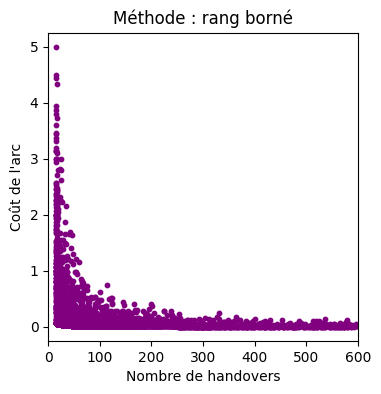

In [24]:
plt.figure(figsize=(4,4))
#plt.title('Weight method: '+method)
plt.title('Méthode : rang borné')
plt.scatter(ho_df.nbHO15, ho_df.Weight, s=10, color='purple')
plt.xlabel('Nombre de handovers')
plt.ylabel('Coût de l\'arc')
plt.xlim(0,600)

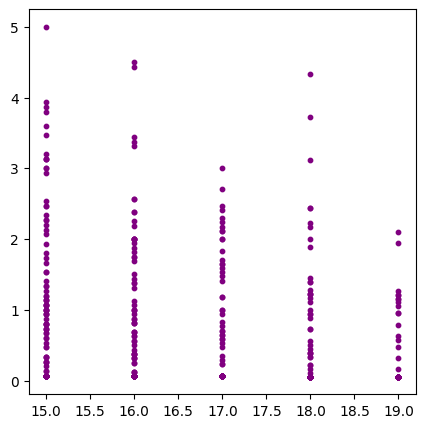

In [27]:
plt.figure(figsize=(5,5))
df = ho_df.loc[ho_df.nbHO15<20]
plt.scatter(df.nbHO15, df.Weight, s=10, color='purple')

In [29]:
df.loc[df.Weight<1]

,srcLocInfo,dstLocInfo,nbHO15,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT,srcRank,dstRank,Weight
index,,,,,,,,,,,,
3243,8102f8100000994e,8102f8100000995b,17,4G,4.818062,45.762236,4G,4.858331,45.753607,28,55,0.058824
3266,8102f8100000994e,8102f8100000999f,18,4G,4.818062,45.762236,4G,4.837227,45.726940,28,33,0.055556
3335,8102f81000009952,8102f81000009959,16,4G,4.827545,45.752980,4G,4.822966,45.733027,27,18,0.625000
3389,8102f81000009952,8102f8100000a4d9,15,4G,4.827545,45.752980,4G,4.829717,45.771114,27,42,0.066667
3524,8102f81000009958,8102f81000009975,16,4G,4.835282,45.761386,4G,4.832776,45.744997,38,28,0.687500
...,...,...,...,...,...,...,...,...,...,...,...,...
19737,8102f8100000ba74,8102f8100000b9ca,18,4G,4.856256,45.718702,4G,4.873892,45.736667,54,68,0.055556
19961,8102f8100000bab9,8102f8100000995c,17,4G,4.857777,45.770137,4G,4.851506,45.760997,62,52,0.647059
20004,8102f8100000bab9,8102f8100000ba3a,15,4G,4.857777,45.770137,4G,4.871882,45.771710,62,75,0.066667


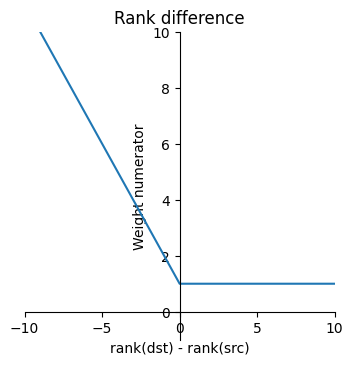

In [15]:
rank_diff = np.arange(-10, 11, 1)
r_src = 0
num = [max(1, r_src-r_dst+1) for r_dst in rank_diff]

fig, ax = plt.subplots(figsize=(4,4))
ax.set_title('Rank difference')
ax.plot(rank_diff, num)
ax.set_xlabel('rank(dst) - rank(src)')
ax.set_ylabel('Weight numerator')
ax.set_xlim(-10,10)
ax.set_ylim(-1,10)
ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)


## 3. NetworkX graphs

In [17]:
def compute_path_ho(data, path):
    path_ho = 0
    for i in range(len(path)-1):
        arc_ho = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['nbHO15'].iloc[0]
        arc_weight = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['Weight'].iloc[0]
        print('Number of handovers between', path[i], 'and', path[i+1],': ', arc_ho, '\tWeight: ', arc_weight)
        path_ho += arc_ho
    return int(path_ho)

In [64]:
G = nx.from_pandas_edgelist(ho_df, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph)
sp = nx.shortest_path(G, ENB_SRC, ENB_DST, weight='Weight', method='bellman-ford') # Bellman-Ford is better for directed graphs

path_ho = compute_path_ho(ho_df, sp)
traffic = np.round(path_ho/TOTAL_HO*100,1)
print('Path length:', len(sp), '\tNumber of handovers:', path_ho, '('+str(traffic)+'%)')

Number of handovers between 8102f8100000ba53 and 8102f81000009f17 :  5712 	Weight:  0.029904561711631753
Number of handovers between 8102f81000009f17 and 8102f810000099ad :  14010 	Weight:  0.04108611865438954
Number of handovers between 8102f810000099ad and 8102f81000009959 :  419456 	Weight:  0.0020387050796172486
Number of handovers between 8102f81000009959 and 8102f81000009993 :  349811 	Weight:  0.00027241243098563377
Number of handovers between 8102f81000009993 and 8102f810000099ac :  126013 	Weight:  0.0008625655724458659
Number of handovers between 8102f810000099ac and 8102f81000009994 :  78731 	Weight:  0.0015409596538030572
Number of handovers between 8102f81000009994 and 8102f81000009952 :  206550 	Weight:  0.0008442193742429965
Number of handovers between 8102f81000009952 and 8102f8100000999e :  117585 	Weight:  0.0005331317663695634
Number of handovers between 8102f8100000999e and 8102f810000099ab :  110698 	Weight:  0.002400727763210989
Number of handovers between 8102f81

### Betweenness centrality

In [110]:
enb_bc = nx.betweenness_centrality(G, weight='Weight')
enb_df['BC'] = enb_df['LocInfo'].map(enb_bc)
ho_df = ho_df.join(enb_df[['LocInfo','BC']].set_index('LocInfo'), on='dstLocInfo')
ho_df

,srcLocInfo,dstLocInfo,nbHO15,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT,Weight,BC
index,,,,,,,,,,,
3240,8102f8100000994e,8102f81000009952,174,4G,4.818062,45.762236,4G,4.827545,45.752980,0.005747,0.190764
3241,8102f8100000994e,8102f81000009957,3879,4G,4.818062,45.762236,4G,4.826112,45.774444,0.000258,0.001884
3242,8102f8100000994e,8102f81000009958,1163,4G,4.818062,45.762236,4G,4.835282,45.761386,0.000860,0.098378
3243,8102f8100000994e,8102f8100000995b,17,4G,4.818062,45.762236,4G,4.858331,45.753607,0.058824,0.000000
3245,8102f8100000994e,8102f81000009963,553,4G,4.818062,45.762236,4G,4.830520,45.753373,0.001808,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20194,8102f8100000bad0,8102f81000009b28,64825,4G,4.820179,45.775520,4G,4.819723,45.771390,0.000015,0.030822
20195,8102f8100000bad0,8102f8100000a01d,5663,4G,4.820179,45.775520,4G,4.789162,45.763888,0.000177,0.000000
20196,8102f8100000bad0,8102f8100000a104,15,4G,4.820179,45.775520,4G,4.863723,45.755097,0.066667,0.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x1723a7557f0>,
 'caps': [<matplotlib.lines.Line2D at 0x1723a755fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1723a74bd00>],
 'medians': [<matplotlib.lines.Line2D at 0x1723a75a610>],
 'fliers': [<matplotlib.lines.Line2D at 0x1723a766d90>],
 'means': []}

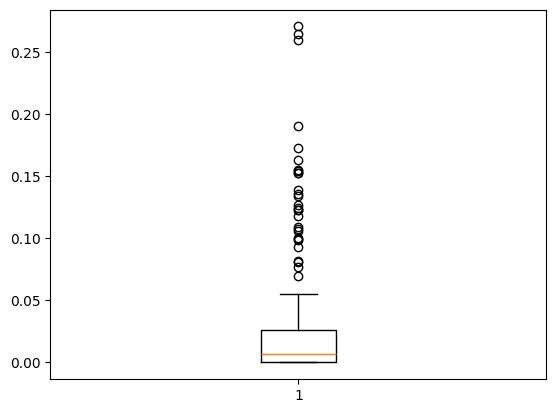

In [67]:
plt.boxplot(enb_bc.values())

In [76]:
np.quantile(list(enb_bc.values()), 0.25)

np.float64(0.0)

## 4. Folium visualization

In [4]:
from folium.plugins import HeatMap

In [5]:
def create_map():
    map = folium.Map([45.73303, 4.82297], tiles="OpenStreetMap", zoom_start=13)
    print('Creating base station map...')
    return map

def add_stations(map, df, name='4G stations'):
    print('Adding '+name+' layer')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_ids = df.srcLocInfo.unique()
    for id in enb_ids:
        enb_data = df.loc[df['srcLocInfo']==id]
        fg.add_child(folium.Marker(
            location=[enb_data['srcLAT'].iloc[-1], enb_data['srcLON'].iloc[-1]],
            popup=enb_data['srcLocInfo'].iloc[-1],
        ))
    map.add_child(fg)
    
def add_stations_by_centrality(map, df, name='4G stations'):
    print('Adding '+name+' layer...')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_color = {0:'blue', 0.007:'green', 0.026:'yellow', 0.05:'orange', 0.5:'red'}
    for idx,row in df.iterrows():
        ec = [v for k,v in enb_color.items() if row['BC'] <= k]
        fg.add_child(folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            popup=row['LocInfo'],
            tooltip='Centrality: '+str(row['BC']),
            color='black',
            weight=1,
            fill=True,
            fill_color=ec[0],
            fill_opacity=0.9,
            radius=10
        ))
    map.add_child(fg)
    
def close_map(map, filename):
    folium.LayerControl().add_to(map)
    map.save('maps\\'+filename)
    print('Closing', filename, 'map.')
    
def add_voronoi(map, points):
    print('Adding Voronoi layer')
    vor = Voronoi(list(zip(points['LAT'].tolist(), points['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name='Voronoi cells', show=True)
    for enb, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        if -1 not in region and region != []:
            region_coords = []
            for vertex in region:
                region_coords.append(vor.vertices[vertex])
            fg.add_child(folium.Polygon(
                region_coords,
                color="black",
                weight=1,
                fill_color="darkgray",
                fill_opacity=0.2,
                fill=True,
            ))
    map.add_child(fg)
    
    
def add_flows(map, data, name='4G Handovers', min_weight=900):
    print('Adding Flow layer', name)
    fg = folium.FeatureGroup(name=name)
    flow_weight = {100000:2, 200000:4, 300000:6, 400000:8, 500000:10}
    flow_color = {2:'blue', 4:'green', 6:'yellow', 8:'orange', 10:'red'}
    for idx, row in data.iterrows():
        if row['nbHO15'] >= min_weight:
            fw = [v for k,v in flow_weight.items() if row['nbHO15'] <= k]
            fg.add_child(folium.PolyLine(
                [(row['srcLAT'], row['srcLON']), (row['dstLAT'], row['dstLON'])],
                color = flow_color[fw[0]],
                weight = fw[0],
                opacity = 0.8,
                tooltip = 'Weight: '+str(row['nbHO15'])
            ))
    map.add_child(fg)
    
    
def add_path(map, data, path_list, name='Path', color='#AA0000'):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    for i in range(1, len(path_list)):
        flow = data.loc[(data['srcLocInfo']==path_list[i-1]) & (data['dstLocInfo']==path_list[i])]
        fg.add_child(folium.PolyLine(
            locations=[[flow['srcLAT'].iloc[0], flow['srcLON'].iloc[0]], [flow['dstLAT'].iloc[0], flow['dstLON'].iloc[0]]],
            color = color,
            opacity = 0.8,
            weight = 5,
            tooltip = 'nbHO: '+str(flow['nbHO15'].iloc[0])+'\nWeight: '+str(flow['Weight'].iloc[0])
        ))
    map.add_child(fg)
    
    
def add_voronoi_path(map, enb_data, cells_data, name='Cells path', color='green'):
    vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name=name, show=True)
    for enb_idx, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
        if -1 not in region and region != []:
            region_coords = []
            if type(cells_data) == list:
                if cell_locinfo in cells_data:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
            else:
                if cell_locinfo in cells_data['LocInfo'].values:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)

In [11]:
lyon = create_map()
folium.TileLayer('CartoDB Positron').add_to(lyon)
add_stations(lyon, ho_df)
add_voronoi(lyon, enb_df)
close_map(lyon, 'lyon_enb_voronoi.html')
lyon

Creating base station map...
Adding 4G stations layer
Adding Voronoi layer
Closing lyon_enb_voronoi.html map.


In [118]:
enb_df['BC'] = enb_df['BC']/100
enb_df

,LocInfo,TECHNO,LON,LAT,Georank,BC
0,8102f8100000999d,4G,4.888138,45.738378,82,0.001491
1,8102f81000009b28,4G,4.819723,45.771390,37,0.030822
2,8102f8100000997e,4G,4.875561,45.753615,72,0.000000
3,8102f81000009976,4G,4.846672,45.729169,42,0.023940
4,8102f81000009959,4G,4.822966,45.733027,18,0.270722
...,...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,74,0.081240
193,8102f8100000997b,4G,4.880686,45.725675,76,0.000000
194,8102f8100000ba70,4G,4.867783,45.701943,71,0.000000
195,8102f8100000996d,4G,4.864943,45.729614,60,0.013946


In [116]:
lyon = create_map()
#heat_data = [[row['LAT'],row['LON']] for idx, row in enb_df.iterrows()]
heat_data = [[row['LAT'],row['LON'], row['BC']] for idx, row in enb_df.iterrows()]

HeatMap(heat_data).add_to(lyon)
lyon

Creating base station map...


In [119]:
lyon = create_map()
add_stations_by_centrality(lyon, enb_df)
HeatMap(heat_data).add_to(lyon)
close_map(lyon, 'lyon_stations_centrality.html')
lyon

Creating base station map...
Adding 4G stations layer...
Closing lyon_stations_centrality.html map.


In [66]:
lyon = create_map()
#add_stations_by_centrality(lyon, ho_df)
add_voronoi(lyon, enb_df)

#add_flows(lyon, ho_df.loc[ho_df.srcLocInfo.isin(sp)])
add_voronoi_path(lyon, enb_df, cells_data=sp, name='Cells path', color='green')
add_path(lyon, ho_df, path_list=sp)
close_map(lyon, 'lyon_shortest_path.html')
lyon

Creating base station map...
Adding Voronoi layer
Adding Path layer Path
Closing lyon_shortest_path.html map.
